### 命令行查看gpu版本

In [1]:
!nvidia-smi

Sat Feb  4 04:07:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 下载必要的torch和torchvision包

In [3]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.12.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.12.0 which is incompatible.


### 下载加载必要数据的py文件

In [2]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2023-02-04 04:08:24--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.39K  --.-KB/s    in 0s      

2023-02-04 04:08:25 (75.5 MB/s) - ‘pytorchcv.py’ saved [6540/6540]



### 查看是否可以使用cuda

In [4]:
import torch

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### 开始尝试训练LeNet

#### 导入相关的包和数据

In [7]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### 定义普通多层卷积神经网络

In [9]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

#### 用LeNet测试CIFAR-10

In [10]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


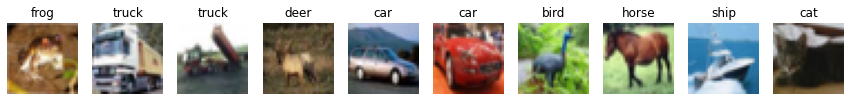

In [11]:
display_dataset(trainset,classes=classes)

#### 定义LeNet

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [13]:
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=20, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.771, Val acc=0.640, Train loss=0.046, Val loss=0.084
Epoch  1, Train acc=0.780, Val acc=0.640, Train loss=0.044, Val loss=0.082
Epoch  2, Train acc=0.787, Val acc=0.642, Train loss=0.043, Val loss=0.084
Epoch  3, Train acc=0.791, Val acc=0.635, Train loss=0.041, Val loss=0.087
Epoch  4, Train acc=0.795, Val acc=0.632, Train loss=0.041, Val loss=0.088
Epoch  5, Train acc=0.803, Val acc=0.626, Train loss=0.039, Val loss=0.093
Epoch  6, Train acc=0.810, Val acc=0.638, Train loss=0.038, Val loss=0.093
Epoch  7, Train acc=0.812, Val acc=0.636, Train loss=0.037, Val loss=0.094
Epoch  8, Train acc=0.818, Val acc=0.637, Train loss=0.036, Val loss=0.096
Epoch  9, Train acc=0.823, Val acc=0.630, Train loss=0.035, Val loss=0.097
Epoch 10, Train acc=0.825, Val acc=0.634, Train loss=0.034, Val loss=0.098
Epoch 11, Train acc=0.830, Val acc=0.630, Train loss=0.034, Val loss=0.100
Epoch 12, Train acc=0.836, Val acc=0.632, Train loss=0.033, Val loss=0.101
Epoch 13, Train acc=0.840

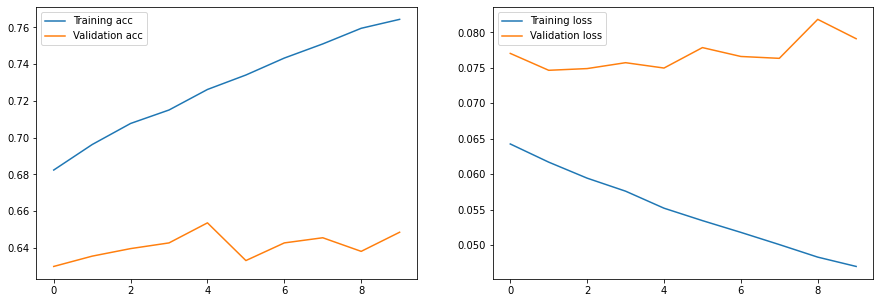

In [31]:
plot_results(hist)

In [ ]:
plot_results(hist)

In [19]:
net_GPU = LeNet().to(device)

In [20]:
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testloader2 = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)

In [29]:
opt2 = torch.optim.Adam(net_GPU.parameters(),lr=0.001)
hist2 = train(net_GPU, trainloader2, testloader2, epochs=20, optimizer=opt2, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.845, Val acc=0.601, Train loss=0.031, Val loss=0.139
Epoch  1, Train acc=0.853, Val acc=0.607, Train loss=0.029, Val loss=0.142
Epoch  2, Train acc=0.857, Val acc=0.601, Train loss=0.029, Val loss=0.148
Epoch  3, Train acc=0.863, Val acc=0.600, Train loss=0.027, Val loss=0.154
Epoch  4, Train acc=0.866, Val acc=0.600, Train loss=0.027, Val loss=0.156
Epoch  5, Train acc=0.870, Val acc=0.599, Train loss=0.026, Val loss=0.164
Epoch  6, Train acc=0.872, Val acc=0.595, Train loss=0.025, Val loss=0.168
Epoch  7, Train acc=0.876, Val acc=0.596, Train loss=0.025, Val loss=0.176
Epoch  8, Train acc=0.882, Val acc=0.589, Train loss=0.024, Val loss=0.175
Epoch  9, Train acc=0.883, Val acc=0.597, Train loss=0.023, Val loss=0.190
Epoch 10, Train acc=0.886, Val acc=0.598, Train loss=0.023, Val loss=0.184
Epoch 11, Train acc=0.889, Val acc=0.594, Train loss=0.023, Val loss=0.186
Epoch 12, Train acc=0.891, Val acc=0.593, Train loss=0.022, Val loss=0.194
Epoch 13, Train acc=0.894

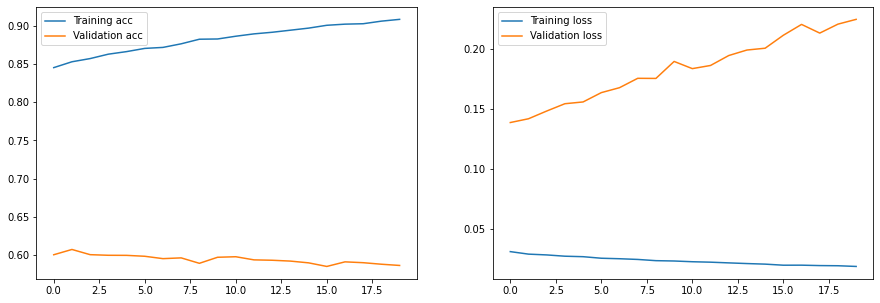

In [30]:
plot_results(hist2)

In [25]:
!nvidia-smi

Sat Feb  4 04:44:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |    970MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> 上面两个模型我们都可以看到最后过拟合了，最高的test accuracy只有65%左右。